This notebook extracts the resting-state temporal dynamics of brain networks.


We first use an atlas to construct a reasonably realistic model of interacting regions or nodes. We then use the atlas to mask BOLD activities of the nodes, remove confounds from the data, and finally extract the time-series for each node. This process ends up with a matrix of time-series of size n_subjects * n_nodes * n_timesteps, e.g., 32*39*125 in case of using regions of interest from \cite{@dosenbach2007}.


**WARNING**: *This notebook requires full BIDS dataset including fmriprep derivatives and preprocessed scans.*

In [2]:
import numpy as np
import xarray as xr
import pandas as pd

from bids import BIDSLayout

import nilearn
from nilearn import datasets, plotting, regions, maskers, image, connectome


/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


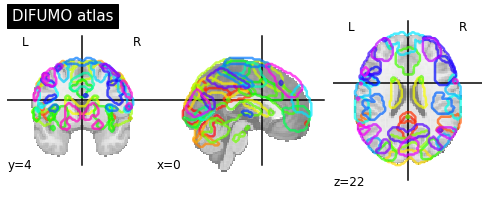

In [33]:
# DIFUMO Atlas

atlas = datasets.fetch_atlas_difumo(dimension=64, resolution=2, legacy_format=False)

# DEBUG atlas.keys()

atlas_coordinates = nilearn.plotting.find_probabilistic_atlas_cut_coords(maps_img=atlas.maps)

nilearn.plotting.plot_prob_atlas(atlas.maps, title='DIFUMO atlas')


In [ ]:
# Yeo2011 Atlas

# Steps: 
# 1. fetch atlas, 2. relabel atlas for continuity, 3. resample images, 4. mask and extract time series

# atlas = datasets.fetch_atlas_yeo_2011()['thick_7'],
# merge voxels belonging to the same network based on spatial continuity
# atlas_relabeled = nilearn.regions.connected_label_regions(atlas)
# nilearn.plotting.plot_roi(
#   atlas_relabeled,
# 	cut_coords=range(-30,70,10),
# 	display_mode='z',
# 	title='Yeo Atlas (voxels are re-labeled for continuity)')
# atlas_coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_relabeled)
# atlas_resampled = nilearn.image.resample_to_img(atlas_relabeled, func)


In [61]:
# load resting-state session from the BIDS dataset

layout = BIDSLayout('data/julia2018_x5alias',
                    derivatives=True,
                    database_path='tmp/pybids_cache/julia2018')

# all_subjects = layout.get_subject()
TR = layout.get_tr(task='rest')

images = layout.get(task='rest',
                    desc='preproc',
                    suffix='bold',
                    scope='fmriprep',
                    extension='nii.gz',
                    return_type='filename')

mask_images = layout.get(task='rest',
                         desc='brain',
                         suffix='mask',
                         scope='fmriprep',
                         extension='nii.gz',
                         return_type='filename')

confounds_files = layout.get(task='rest',
                             desc='confounds',
                             suffix='timeseries',
                             scope='fmriprep',
                             extension='tsv',
                             return_type='filename')

confounds_cols = ['trans_x', 'trans_y', 'trans_z',
                  'csf', #'whitematter',
                  'rot_x', 'rot_y', 'rot_z',
                  'global_signal',
                  'a_comp_cor_00', 'a_comp_cor_01',
                  ]

In [ ]:

# extract resting timeseries
import re
from tqdm import tqdm

timeseries = {}
subjects = []

for img, mask_img, confounds in tqdm(zip(images, mask_images, confounds_files)):

    subject = re.search('func/sub-(.*)_ses', img)[1]
    subjects.append(subject)

    # yeo2011
    # resampled_atlas = nilearn.image.resample_to_img(atlas_relabeled, img)

    masker = nilearn.maskers.NiftiMapsMasker(
        atlas.maps,
        mask_img=mask_img,
        detrend=True,
        standardize=True,
        t_r = TR,
        verbose=0)

        # for some reasons, using cache causes signal extraction to fail
        # memory='tmp/nilearn_cache', memory_level=1,

    confounds = pd.read_csv(confounds, sep='\t')[confounds_cols].values
    ts = masker.fit_transform(img, confounds=confounds).transpose(1, 0)
    
    timeseries[subject] = ts.T

# reshape dim-0 is subject, dim-1 is region, dim-2 is time point
timeseries = np.array(list(timeseries.values())).transpose(0,2,1)

# plt.imshow(timeseries[0].T)
# plt.title('subject-00 time-series - {timeseries[0].shape[1]} regions')
# plt.show()


In [ ]:
# DEBUG: plot difumo-based connectome

# conn = nilearn.connectome.ConnectivityMeasure(kind='correlation')
# conn.fit_transform(timeseries.values())

# np.fill_diagonal(conn.mean_, 0)

# drop missing yeo2011-based labels
# node_coords = pd.DataFrame(atlas_coordinates).drop(index=[32, 3, 4, 5, 39, 9, 11, 48]).values
# node_coords = atlas_coordinates  # difumo

# # skip the background label (index-0)
# # plotting.plot_matrix(conn.mean_, labels=list(range(1,42)), vmax=0.8, vmin=-0.8, reorder=True)

# # plot connectome with 80% edge strength in the connectivity
# plotting.plot_connectome(conn.mean_, node_coordinates,
#                          edge_threshold="95%",
#                          title='Average connectivity in DIFUMO 64/2 atlas')

In [122]:
groups = pd.Series([s[:4] for s in subjects], index=subjects, name='group')
groups.index.name = 'subject'
groups = xr.DataArray(groups)

atlas_regions = pd.concat([atlas.labels, pd.DataFrame(atlas_coordinates)], axis=1)
atlas_regions.rename(columns={0: 'mni152_x', 1: 'mni152_y', 2: 'mni152_z'}, inplace=True)
atlas_regions.drop(columns=['component'], inplace=True)
atlas_regions.set_index('difumo_names', inplace=True)

ds = xr.Dataset({
  'timeseries': (['subject', 'region', 'timestep'], timeseries),
  'groups': groups
})

ds.coords['timestep']  = range(0,125)
ds.coords['region'].attrs['description'] = 'DIFUMO label'
ds.attrs['description'] = 'Resting-state time series from fmriprep scans based on DIFUMO atlas'
ds.coords['subject'].attrs['description'] = ('subject identifier; AVGPxx for action video'
                                             'gamers and NVGPxx for non-video gamers')
ds['groups'].attrs['description'] = ('AVGP for action video gamers and NVGP for'
                                             'non-video gamers. Indexed by subject coordinates')

# add subject  data
PARTICIPANTS = pd.read_csv('data/julia2018/participants.tsv', sep='\t')
PARTICIPANTS.rename(columns={'participant_id': 'subject'}, inplace=True)
PARTICIPANTS['subject'] = PARTICIPANTS['subject'].apply(
  lambda x: x.split('-')[1])
PARTICIPANTS.set_index('subject', inplace=True)

ds = xr.merge([ds, PARTICIPANTS.to_xarray(), atlas_regions.to_xarray()])

# fix missing resting state data
ds['groups'] = xr.DataArray([subj[:4] for subj in ds['subject'].values], dims=['subject'])

ds.to_netcdf('data/julia2018_resting/timeseries_difumo_64_2.nc', engine='netcdf4')
ds

<xarray.Dataset>
Dimensions:                      (subject: 34, region: 64, timestep: 125,
                                  difumo_names: 64)
Coordinates:
  * subject                      (subject) object 'AVGP01' ... 'NVGP19NEW'
  * timestep                     (timestep) int64 0 1 2 3 4 ... 121 122 123 124
  * difumo_names                 (difumo_names) object 'Superior frontal sulc...
Dimensions without coordinates: region
Data variables: (12/18)
    timeseries                   (subject, region, timestep) float64 -0.8583 ...
    groups                       (subject) <U4 'AVGP' 'AVGP' ... 'NVGP' 'NVGP'
    age                          (subject) float64 27.0 19.0 23.0 ... 19.0 22.0
    sex                          (subject) object 'M' 'M' 'M' ... 'M' 'M' 'M'
    group                        (subject) object 'AVGP' 'AVGP' ... 'NVGP'
    preprocessed_beh             (subject) bool True True True ... True True
    ...                           ...
    gm                           (difumo_names) float64 0.69 0.8447 ... 0.7033
    wm                           (difumo_names) float64 0.1857 ... 0.2604
    csf                          (difumo_names) float64 0.1169 ... 0.03633
    mni152_x                     (difumo_names) float64 -25.62 20.74 ... -11.79
    mni152_y                     (difumo_names) float64 27.52 -63.13 ... 11.56
    mni152_z                     (difumo_names) float64 47.22 -18.02 ... 3.054
Attributes:
    description:  Resting-state time series from fmriprep scans based on DIFU...